<a href="https://colab.research.google.com/github/madhanmohans/Cross-Site-Scripting-Detection/blob/main/XSS_detection_%7C_Phase_2_work.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import re
import itertools
import numpy as np
import pandas as pd
from nltk.util import ngrams
import matplotlib.pyplot as plt
from sklearn import preprocessing
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
df = pd.read_csv("/content/Payloads.csv", encoding="UTF-8") # using UTF-8 encoding

# Data preprocessing

In [ ]:
df.head()

,Payloads,Class
0,http://www.nwce.gov.uk/search_process.php?keyw...,Malicious
1,http://www.manchester.gov.uk/site/scripts/goog...,Malicious
2,http://www.ldsmissions.com/us/index.php?action...,Malicious
3,http://education.powys.gov.uk/english/adult_ed...,Malicious
4,http://www.northwarks.gov.uk/site/scripts/goog...,Malicious


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43219 entries, 0 to 43218
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Payloads  43218 non-null  object
 1   Class     43217 non-null  object
dtypes: object(2)
memory usage: 675.4+ KB


In [ ]:
df.shape

(43219, 2)

In [ ]:
# find duplicate rows

df[df.duplicated()].shape

(546, 2)

In [ ]:
# drop duplicate rows

df.drop(df[df.duplicated()].index, inplace=True)
df.shape

(42673, 2)

In [ ]:
pd.isnull(df).sum() # find null values

Payloads    1
Class       2
dtype: int64

In [ ]:
df = df.dropna() # drop null values

In [ ]:
pd.isnull(df).sum()

Payloads    0
Class       0
dtype: int64

In [ ]:
df['Class'].unique()

array(['Malicious', 'Benign', '1'], dtype=object)

In [ ]:
df.drop(df[(df['Class'] == '1')].index, inplace=True)

In [ ]:
df['Class'].unique()

array(['Malicious', 'Benign'], dtype=object)

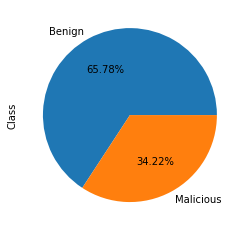

In [ ]:
df['Class'].value_counts().plot(kind='pie',autopct='%1.2f%%')
plt.show()

In [ ]:
label_encoder = preprocessing.LabelEncoder()
df['Class']= label_encoder.fit_transform(df['Class']) 

In [ ]:
df['Class'].unique()

array([1, 0])

In [ ]:
X = df["Payloads"]
y = df["Class"]

In [ ]:
# tokenization on the payloads

tokenizer = Tokenizer(filters='', char_level=True, lower=False, oov_token=1)

tokenizer.fit_on_texts(X)
n_char = len(tokenizer.word_index.keys())

total_seq = tokenizer.texts_to_sequences(X)
# val_seq = tokenizer.texts_to_sequences(X)

print('Before tokenization: ')
print(df.iloc[0]['Payloads'])
print('\nAfter tokenization: ')
print(total_seq[0])

Before tokenization: 
http://www.nwce.gov.uk/search_process.php?keyword=%22%3e%3cscript%3ealert%28document.cookie%29%3b%3c<br>%2fscript%3e

After tokenization: 
[13, 4, 4, 15, 41, 25, 25, 19, 19, 19, 18, 9, 19, 12, 3, 18, 22, 6, 28, 18, 16, 33, 25, 10, 3, 5, 7, 12, 13, 59, 15, 7, 6, 12, 3, 10, 10, 18, 15, 13, 15, 44, 33, 3, 24, 19, 6, 7, 14, 26, 31, 34, 34, 31, 32, 3, 31, 32, 12, 10, 12, 7, 8, 15, 4, 31, 32, 3, 5, 11, 3, 7, 4, 31, 34, 46, 14, 6, 12, 16, 17, 3, 9, 4, 18, 12, 6, 6, 33, 8, 3, 31, 34, 47, 31, 32, 23, 31, 32, 12, 62, 23, 7, 61, 31, 34, 21, 10, 12, 7, 8, 15, 4, 31, 32, 3]


In [ ]:
# padding done to equalize each url length. 

sequence_length = np.array([len(i) for i in total_seq])
sequence_length = np.percentile(sequence_length, 99).astype(int)
print(f'Before padding: \n {total_seq[0]}')

total_seq = pad_sequences(total_seq, padding='post', maxlen=sequence_length)
# val_seq = pad_sequences(val_seq, padding='post', maxlen=sequence_length)

print(f'After padding: \n {total_seq[0]}')

Before padding: 
 [13, 4, 4, 15, 41, 25, 25, 19, 19, 19, 18, 9, 19, 12, 3, 18, 22, 6, 28, 18, 16, 33, 25, 10, 3, 5, 7, 12, 13, 59, 15, 7, 6, 12, 3, 10, 10, 18, 15, 13, 15, 44, 33, 3, 24, 19, 6, 7, 14, 26, 31, 34, 34, 31, 32, 3, 31, 32, 12, 10, 12, 7, 8, 15, 4, 31, 32, 3, 5, 11, 3, 7, 4, 31, 34, 46, 14, 6, 12, 16, 17, 3, 9, 4, 18, 12, 6, 6, 33, 8, 3, 31, 34, 47, 31, 32, 23, 31, 32, 12, 62, 23, 7, 61, 31, 34, 21, 10, 12, 7, 8, 15, 4, 31, 32, 3]
After padding: 
 [13  4  4 ...  0  0  0]


In [ ]:
## Creating a dictionary of all the permutations of the characters in the string.
## The key for each entry is a tuple containing all possible combinations of characters from the original string.
## The value for each entry is an integer that represents its position in the list of features (i.e., feature vector).

alphanum = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z','0','1','2','3','4','5','6','7','8','9']
permutations = itertools.product(alphanum, repeat=3)
featuresDict = {}
counter = 0
for perm in permutations:
    #print(perm)
    f=''
    for char in perm:
        f = f+char;
    featuresDict[(''.join(perm))] = counter
    counter = counter + 1

In [ ]:
# Taking the url and converting it to lowercase, 
# removing all nonalphanumeric characters (spaces, slashes), then creating a list of tuples.

def generate_ngram(url):
    s = url.lower()
    s = ''.join(e for e in s if e.isalnum())
    processedList = []
    for tuples in list(ngrams(s,3)): # n = 3, trigram
        processedList.append((''.join(tuples)))
    return processedList

In [ ]:
# Generating ngrams from the url and adding them to a dictionary.
# Adding these ngrams to the X matrix, which contains all of our features for each row in our dataframe.
# Finally, it assigns y as an integer value based on whether or not the link was labeled as malicious or not (0 = benign, 1 = malicious).

def preprocess_urls(dataframe, X, y):
    #print(dataframe)
    for index,row in df.iterrows():
        url = row['url'].strip().replace("https://","") # stripping https urls
        url = row['url'].strip().replace("http://","") # stripping http urls
        url = url.replace("http://","")
        url = re.sub(r'\.[A-Za-z0-9]+/*','',url)
        for ngram in generate_ngram(url):
            try:
                X[index][featuresDict[ngram]] = X[index][featuresDict[ngram]] + 1 # adds ngram
            except:
                print(ngram,"doesn't exist")
        y[index] = int(row['label'])
    return (X,y)